In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import cv2
import os

import random

In [0]:

base = '/content/drive/My Drive/NewImages'

#os.mkdir(test)
images = os.listdir(base)


In [0]:
'''
from skimage.transform import resize

target_size = 224

def preprocess_image(x):
    # Resize the image to have the shape of (224,224)
    x = resize(x, (target_size, target_size),
            mode='constant',
            anti_aliasing=False)
    
    # convert to 3 channel (RGB)
    x = np.stack((x,)*3, axis=-1) 
    
    # Make sure it is a float32, here is why 
    # https://www.quora.com/When-should-I-use-tf-float32-vs-tf-float64-in-TensorFlow
    return x.astype(np.float32)
 '''

In [0]:
sav = '/content/drive/My Drive/Resized Images'
new_imgs = os.listdir(sav)
newnew_imgs = []
#print(len(new_imgs))
Y = []


for i in new_imgs:
  
  j = i.split("_")[-1]
  j = j.split(".")[0]
  
  if(j == "10"):
    #ten+=1
    j = "5"
  if(j!="2" and j!="3"):
    Y.append(int(j))
    newnew_imgs.append(i) #Commenting it as we have image list aleardy.
    present[int(j)]=True

Y = np.asarray(Y, dtype = 'int32')

In [0]:
images = []
for i in newnew_imgs:
  img = cv2.imread("%s/%s"%(sav,i))
  images.append(img)
images = np.asarray(images)
np.save("/content/drive/My Drive/images_file_resized", images)
del newnew_imgs

In [0]:
images = np.load('/content/drive/My Drive/images_file_resized.npy')
print(images.shape)

(28557, 224, 224, 3)


In [0]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(images,Y,test_size=0.1)
del images
del Y

In [0]:
for i in range(5):
  print(y_train[i])
  if(y_train[i] == 9):
    print(i)
    plt.imshow(X_train[i])
plt.imshow(X_train[0])


[0. 0. 0. 0. 0. 0. 0. 1.]


ValueError: ignored

8


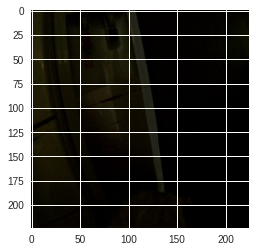

In [0]:
plt.imshow(X_train[0])
print(y_train[0])

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_train = np.delete(y_train, [2,3], axis=1)
y_val = np.delete(y_val, [2,3], axis=1)

Using TensorFlow backend.


In [0]:
print(y_val.shape,X_val.shape)

(2856, 8) (2856, 224, 224, 3)


In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Input, Dropout,Flatten
from keras.models import Model


In [0]:
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)

In [0]:
input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(input_shape = (224,224,3),include_top=True,weights='imagenet',input_tensor=input_tensor)

Instructions for updating:
Colocations handled automatically by placer.
14540800/14536120 [==============================] - 1s 0us/step


In [0]:
np.save('/content/drive/My Drive/y_train.npy',y_train)

In [0]:
new_layer = Dense(256, activation='relu')(base_model.output)
new_layer = Dropout(.25)(new_layer)
#model.summary()
#flatten_layer = Flatten()(new_layer)
output_tensor = Dense(8, activation='softmax')(new_layer)
model = Model(inputs=input_tensor, outputs=output_tensor)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                 

In [0]:
from keras import layers
from keras import models
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics = ['accuracy'])

In [0]:
from sklearn.utils import shuffle
def load_data_generator(x, y, batch_size=64):
    num_samples = x.shape[0]
    while 1:  # Loop forever so the generator never terminates
        try:
            shuffle(x)
            for i in range(0, num_samples, batch_size):
                x_data = x[i:i+batch_size]
                y_data = y[i:i + batch_size]
            
                # convert to numpy array since this what keras required
                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            print(err)

In [0]:
train_generator = load_data_generator(X_train, y_train, batch_size=64)
model.fit_generator(generator=train_generator, verbose=2,epochs=3,steps_per_epoch=1000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
 - 776s - loss: 1.0903 - acc: 0.9234
Epoch 2/3
 - 760s - loss: 0.1051 - acc: 0.9956
Epoch 3/3
 - 761s - loss: 0.0262 - acc: 0.9983


In [0]:
model.save('/content/drive/My Drive/mobile_net.h5')

In [0]:
model.load_weights('/content/drive/My Drive/mobile_net.h5')

In [0]:
y_predicted = model.predict(X_val)

In [0]:
print(y_predicted.shape,y_val.shape)
correct = 0
for i in range(len(y_predicted)):
  ma=0
  mi=0
  for j in range(6):
    if(y_predicted[i][j]>ma):
      ma = y_predicted[i][j]
      mi = j
  if(y_val[i][mi] == 1): correct+=1
print(correct/len(y_val))
  

(2856, 8) (2856, 8)
0.7128851540616247
